In [1]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

2023-05-12 17:04:22.367355: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:


def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1) 
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1 
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # + noise 
    return time, series[..., np.newaxis].astype(np.float32)

In [3]:
n_steps = 50
time, series = generate_time_series(10000, n_steps + 1)

In [5]:
time.shape, series.shape

((51,), (10000, 51, 1))

In [7]:
# 7k/10k for training set
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]

# Next 2k/10k for validation set
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]

# Next 1k/10k for test set
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

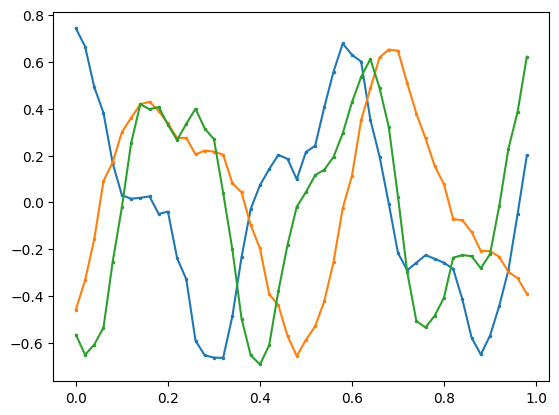

In [8]:
# There are 7K TS data, plotting only 3 of them

plt.plot(time[:n_steps], X_train[0, :, 0], marker='.', markersize=3)
plt.plot(time[:n_steps], X_train[1, :, 0], marker='.', markersize=3)
plt.plot(time[:n_steps], X_train[2, :, 0], marker='.', markersize=3)

In [6]:
print("Train ", X_train.shape, y_train.shape)
print("Valid ", X_valid.shape, y_valid.shape)
print("Test ", X_test.shape, y_test.shape)

Train  (7000, 50, 1) (7000, 1)
Valid  (2000, 50, 1) (2000, 1)
Test  (1000, 50, 1) (1000, 1)


In [12]:
# Use existing validation set itself to get an idea about mse

y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

2023-05-12 17:16:40.916857: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0.021557575

In [8]:
y_pred.shape, y_valid.shape, X_valid.shape

((2000, 1), (2000, 1), (2000, 50, 1))

# Fully Connected Network as shown below

In [13]:
# building simple sequential model to consume vector [50, 1] and produce 1 vector, the next 51st value
# This is basically linear regression
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 1ms/step - loss: 0.1455 - accuracy: 0.0000e+00 - val_loss: 0.0570 - val_accuracy: 0.0000e+00
Epoch 2/20
219/219 [==============================] - 0s 938us/step - loss: 0.0387 - accuracy: 0.0000e+00 - val_loss: 0.0303 - val_accuracy: 0.0000e+00
Epoch 3/20
219/219 [==============================] - 0s 918us/step - loss: 0.0216 - accuracy: 0.0000e+00 - val_loss: 0.0179 - val_accuracy: 0.0000e+00
Epoch 4/20
219/219 [==============================] - 0s 913us/step - loss: 0.0139 - accuracy: 0.0000e+00 - val_loss: 0.0124 - val_accuracy: 0.0000e+00
Epoch 5/20
219/219 [==============================] - 0s 919us/step - loss: 0.0104 - accuracy: 0.0000e+00 - val_loss: 0.0098 - val_accuracy: 0.0000e+00
Epoch 6/20
219/219 [==============================] - 0s 910us/step - loss: 0.0086 - accuracy: 0.0000e+00 - val_loss: 0.0083 - val_accuracy: 0.0000e+00
Epoch 7/20
219/219 [==============================] - 0s 902us/step - loss: 0.0076 - accur

In [14]:
# use model to predict 51st TS data point
y1 = model.predict(X_test)

# calculate mse to get baseline metric
np.mean(keras.losses.mean_squared_error(y_test, y1))

32/32 [==============================] - 0s 641us/step


0.003963059

In [11]:
y1.shape, y_test.shape, X_valid[:, -1].shape, y_valid.shape

((1000, 1), (1000, 1), (2000, 1), (2000, 1))

In [29]:
# build single layer RNN model
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

# compile
model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

# Fit the model using 7K data to train and 2k data to validate
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid))

Epoch 1/200
219/219 [==============================] - 2s 5ms/step - loss: 1.0566 - accuracy: 0.0000e+00 - val_loss: 0.9999 - val_accuracy: 0.0000e+00
Epoch 2/200
219/219 [==============================] - 1s 4ms/step - loss: 0.8592 - accuracy: 0.0000e+00 - val_loss: 0.7960 - val_accuracy: 0.0000e+00
Epoch 3/200
219/219 [==============================] - 1s 4ms/step - loss: 0.7438 - accuracy: 0.0000e+00 - val_loss: 0.7247 - val_accuracy: 0.0000e+00
Epoch 4/200
219/219 [==============================] - 1s 4ms/step - loss: 0.6165 - accuracy: 0.0000e+00 - val_loss: 0.5376 - val_accuracy: 0.0000e+00
Epoch 5/200
219/219 [==============================] - 1s 4ms/step - loss: 0.4916 - accuracy: 0.0000e+00 - val_loss: 0.4954 - val_accuracy: 0.0000e+00
Epoch 6/200
219/219 [==============================] - 1s 4ms/step - loss: 0.4557 - accuracy: 0.0000e+00 - val_loss: 0.4502 - val_accuracy: 0.0000e+00
Epoch 7/200
219/219 [==============================] - 1s 4ms/step - loss: 0.4154 - accuracy: 

Epoch 55/200
219/219 [==============================] - 1s 4ms/step - loss: 0.1396 - accuracy: 0.0000e+00 - val_loss: 0.1409 - val_accuracy: 0.0000e+00
Epoch 56/200
219/219 [==============================] - 1s 4ms/step - loss: 0.1392 - accuracy: 0.0000e+00 - val_loss: 0.1452 - val_accuracy: 0.0000e+00
Epoch 57/200
219/219 [==============================] - 1s 4ms/step - loss: 0.1399 - accuracy: 0.0000e+00 - val_loss: 0.1393 - val_accuracy: 0.0000e+00
Epoch 58/200
219/219 [==============================] - 1s 4ms/step - loss: 0.1399 - accuracy: 0.0000e+00 - val_loss: 0.1403 - val_accuracy: 0.0000e+00
Epoch 59/200
219/219 [==============================] - 1s 4ms/step - loss: 0.1395 - accuracy: 0.0000e+00 - val_loss: 0.1406 - val_accuracy: 0.0000e+00
Epoch 60/200
219/219 [==============================] - 1s 4ms/step - loss: 0.1387 - accuracy: 0.0000e+00 - val_loss: 0.1397 - val_accuracy: 0.0000e+00
Epoch 61/200
219/219 [==============================] - 1s 4ms/step - loss: 0.1393 - acc

Epoch 109/200
219/219 [==============================] - 1s 4ms/step - loss: 0.1394 - accuracy: 0.0000e+00 - val_loss: 0.1421 - val_accuracy: 0.0000e+00
Epoch 110/200
219/219 [==============================] - 1s 4ms/step - loss: 0.1395 - accuracy: 0.0000e+00 - val_loss: 0.1392 - val_accuracy: 0.0000e+00
Epoch 111/200
219/219 [==============================] - 1s 4ms/step - loss: 0.1394 - accuracy: 0.0000e+00 - val_loss: 0.1401 - val_accuracy: 0.0000e+00
Epoch 112/200
219/219 [==============================] - 1s 4ms/step - loss: 0.1396 - accuracy: 0.0000e+00 - val_loss: 0.1402 - val_accuracy: 0.0000e+00
Epoch 113/200
219/219 [==============================] - 1s 4ms/step - loss: 0.1398 - accuracy: 0.0000e+00 - val_loss: 0.1397 - val_accuracy: 0.0000e+00
Epoch 114/200
219/219 [==============================] - 1s 4ms/step - loss: 0.1386 - accuracy: 0.0000e+00 - val_loss: 0.1435 - val_accuracy: 0.0000e+00
Epoch 115/200
219/219 [==============================] - 1s 4ms/step - loss: 0.139

219/219 [==============================] - 1s 4ms/step - loss: 0.1392 - accuracy: 0.0000e+00 - val_loss: 0.1478 - val_accuracy: 0.0000e+00
Epoch 163/200
219/219 [==============================] - 1s 4ms/step - loss: 0.1395 - accuracy: 0.0000e+00 - val_loss: 0.1408 - val_accuracy: 0.0000e+00
Epoch 164/200
219/219 [==============================] - 1s 4ms/step - loss: 0.1390 - accuracy: 0.0000e+00 - val_loss: 0.1395 - val_accuracy: 0.0000e+00
Epoch 165/200
219/219 [==============================] - 1s 4ms/step - loss: 0.1394 - accuracy: 0.0000e+00 - val_loss: 0.1404 - val_accuracy: 0.0000e+00
Epoch 166/200
219/219 [==============================] - 1s 4ms/step - loss: 0.1394 - accuracy: 0.0000e+00 - val_loss: 0.1397 - val_accuracy: 0.0000e+00
Epoch 167/200
219/219 [==============================] - 1s 4ms/step - loss: 0.1395 - accuracy: 0.0000e+00 - val_loss: 0.1390 - val_accuracy: 0.0000e+00
Epoch 168/200
219/219 [==============================] - 1s 4ms/step - loss: 0.1394 - accuracy: 

In [30]:
# for each of 1k data, predict 51st value
y2 = model.predict(X_test)
y2.shape

32/32 [==============================] - 0s 1ms/step


(1000, 1)

In [31]:
# calculate mse metric
np.mean(keras.losses.mean_squared_error(y_test, y2))

0.14441986

In [14]:
y2.shape, y_test.shape

((1000, 1), (1000, 1))

### RNN with 3 layers of 20 cells and outputs 20 TS data

In [33]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[50, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(20)
])
model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, epochs=30)


Epoch 1/30
219/219 [==============================] - 3s 9ms/step - loss: 0.0487 - accuracy: 0.0000e+00
Epoch 2/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0081 - accuracy: 0.0000e+00
Epoch 3/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0052 - accuracy: 0.0000e+00
Epoch 4/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0044 - accuracy: 0.0000e+00
Epoch 5/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0039 - accuracy: 0.0000e+00
Epoch 6/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0037 - accuracy: 0.0000e+00
Epoch 7/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0034 - accuracy: 0.0000e+00
Epoch 8/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0033 - accuracy: 0.0000e+00
Epoch 9/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0033 - accuracy: 0.0000e+00
Epoch 10/30
219/219 [==============================] - 2s 9ms/st

In [63]:
y3 = model.predict(X_test)
np.mean(keras.losses.mean_squared_error(y_test, y3[:, 1]))

32/32 [==============================] - 1s 3ms/step


0.14706314

In [64]:
y3.shape, y_test.shape

((1000, 24, 1), (1000, 1))

# Long Short Term Memory

In [36]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[50, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])
model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))


Epoch 1/30
219/219 [==============================] - 7s 21ms/step - loss: 0.1426 - accuracy: 0.0000e+00 - val_loss: 0.1439 - val_accuracy: 0.0000e+00
Epoch 2/30
219/219 [==============================] - 4s 19ms/step - loss: 0.1418 - accuracy: 0.0000e+00 - val_loss: 0.1445 - val_accuracy: 0.0000e+00
Epoch 3/30
219/219 [==============================] - 4s 19ms/step - loss: 0.1412 - accuracy: 0.0000e+00 - val_loss: 0.1414 - val_accuracy: 0.0000e+00
Epoch 4/30
219/219 [==============================] - 4s 19ms/step - loss: 0.1380 - accuracy: 0.0000e+00 - val_loss: 0.1363 - val_accuracy: 0.0000e+00
Epoch 5/30
219/219 [==============================] - 4s 19ms/step - loss: 0.1241 - accuracy: 0.0000e+00 - val_loss: 0.1163 - val_accuracy: 0.0000e+00
Epoch 6/30
219/219 [==============================] - 4s 19ms/step - loss: 0.1050 - accuracy: 0.0000e+00 - val_loss: 0.1055 - val_accuracy: 0.0000e+00
Epoch 7/30
219/219 [==============================] - 4s 19ms/step - loss: 0.0954 - accuracy: 

In [38]:
y4 = model.predict(X_test)
np.mean(keras.losses.mean_squared_error(y4[:, :, 0], y_test))

32/32 [==============================] - 1s 5ms/step


0.071717516

# Gated Recurrent Unit

In [39]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid", input_shape=[50, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))


Epoch 1/30
219/219 [==============================] - 6s 14ms/step - loss: 0.1415 - val_loss: 0.1400
Epoch 2/30
219/219 [==============================] - 3s 12ms/step - loss: 0.1385 - val_loss: 0.1395
Epoch 3/30
219/219 [==============================] - 3s 12ms/step - loss: 0.1378 - val_loss: 0.1395
Epoch 4/30
219/219 [==============================] - 3s 12ms/step - loss: 0.1377 - val_loss: 0.1395
Epoch 5/30
219/219 [==============================] - 3s 12ms/step - loss: 0.1381 - val_loss: 0.1408
Epoch 6/30
219/219 [==============================] - 3s 12ms/step - loss: 0.1377 - val_loss: 0.1395
Epoch 7/30
219/219 [==============================] - 3s 12ms/step - loss: 0.1374 - val_loss: 0.1410
Epoch 8/30
219/219 [==============================] - 3s 12ms/step - loss: 0.1373 - val_loss: 0.1397
Epoch 9/30
219/219 [==============================] - 3s 12ms/step - loss: 0.1376 - val_loss: 0.1393
Epoch 10/30
219/219 [==============================] - 3s 12ms/step - loss: 0.1371 - val_lo

In [65]:
y5 = model.predict(X_test)
np.mean(keras.losses.mean_squared_error(y5[:, :, 0], y_test))

32/32 [==============================] - 0s 3ms/step


0.0721772